In [63]:
"""
explore_raw_empdata.ipynb
Purpose:
    Basic wrangling and exploration of the raw Data Axle employment data

"""

import pandas as pd

# STEP 1: LOAD DATAFRAME AND GIVE IT MORE INTUITIVE FIELD NAMES

cols_raw = ['CONAME', 'LOCNUM', 'SITE', 'STADDR', 'STCITY', 'ZIP',
            'CNTYCD', 'CCNTY', 'NAICS', 'NAICSD', 'LOCEMP', 
            'YREY2K', 'LMDATE', 'LNGNAM', 'latitude', 'longitude', 'geo_level']

cols_rename = ['CompName', 'LocID', 'SITE', 'Address', 'City', 'ZIP', 
        'CountyID', 'CntyCensus', 'NAICS', 'NAICSD', 'EmpCnt_LocID', 
        'YearEstd', 'DateModified', 'LongName', 'latitude', 'longitude', 'geo_level']

col_rename_dict = dict(zip(cols_raw, cols_rename))

def memory_optimization(in_df):
    '''Takes in a pandas dataframe and converts it to have optimized, low-memory
    data types'''
    # common default data types that can be reduced to more memory-efficient type
    dtype_obj = 'object'
    dtypes_int = ['int64', 'uint64']
    dtypes_float = ['float64']
    
    # category dtype is far more efficient way to store strings if not many unique string values.
    dtype_category = 'category'
    downcast_float = 'float'
    downcast_int = 'integer'
    
    for col in in_df.columns:
        start_dtype = in_df[col].dtype
        if start_dtype in dtypes_int:
            in_df[col] = pd.to_numeric(in_df[col], downcast=downcast_int) # sets to biggest size necessary, not biggest size possible
        elif start_dtype in dtypes_float:
            in_df[col] = pd.to_numeric(in_df[col], downcast=downcast_float)
        elif start_dtype == dtype_obj:
            # if number of unique string vals is less than 40% of the total number of vals in column,
            # then recode as category instead of string, which will save significant memory
            if len(in_df[col].unique()) / len(in_df[col]) < 0.4:
                in_df[col] = in_df[col].astype(dtype_category)
            else:
                continue
        else:
            continue
            
raw_csv = r"P:\Employment Inventory\Employment 2020\Data Axle Raw - DO NOT MODIFY\SACOG Jan 2020.csv"
df_raw = pd.read_csv(raw_csv, usecols=cols_raw)

# change datatypes to significantly reduce df memory usage
memory_optimization(df_raw)

df_raw = df_raw.rename(columns=col_rename_dict)

In [64]:
print(df_raw.columns)
print(df_raw.shape)

Index(['CompName', 'LocID', 'SITE', 'Address', 'City', 'ZIP', 'CountyID',
       'CntyCensus', 'NAICS', 'NAICSD', 'EmpCnt_LocID', 'YearEstd',
       'DateModified', 'LongName', 'latitude', 'longitude', 'geo_level'],
      dtype='object')
(417105, 17)


In [65]:
# Get unique locations
gb_cols = ['CompName', 'Address', 'ZIP', 'latitude', 'longitude', 'EmpCnt_LocID']


df_uniqloc = df_raw[gb_cols].drop_duplicates() \
             .sort_values(by=['EmpCnt_LocID','latitude','longitude','Address','CompName'],
                         ascending=[False, True, True, True, True])

df_uniqloc.shape


(412588, 6)

(array([1.46441e+05, 1.46179e+05, 3.42320e+04, 3.86160e+04, 1.45790e+04,
        3.29000e+03, 7.23500e+03, 4.73000e+03, 1.08900e+03, 3.80600e+03,
        1.21600e+03, 4.60000e+02, 2.82100e+03, 7.35000e+02, 4.05000e+02,
        1.63600e+03, 3.40000e+02, 5.50000e+01, 1.80800e+03, 2.55000e+02,
        5.90000e+01, 5.80000e+02, 1.40000e+02, 2.20000e+01, 6.38000e+02,
        1.06000e+02, 6.60000e+01, 3.32000e+02, 1.58000e+02, 3.50000e+01,
        8.91000e+02, 7.60000e+01, 2.90000e+01, 2.24000e+02, 4.70000e+01,
        2.10000e+01, 4.46000e+02, 4.50000e+01, 2.10000e+01, 1.37000e+02,
        3.50000e+01, 2.70000e+01, 3.29000e+02, 2.70000e+01, 5.00000e+00,
        1.72000e+02, 5.60000e+01, 7.00000e+00, 1.93000e+02, 8.00000e+00,
        7.00000e+00, 7.00000e+01, 7.00000e+00, 6.00000e+00, 9.70000e+01,
        1.30000e+01, 2.00000e+00, 2.80000e+01, 1.30000e+01, 4.62000e+02]),
 array([  0.        ,   1.66666667,   3.33333333,   5.        ,
          6.66666667,   8.33333333,  10.        ,  11.6666

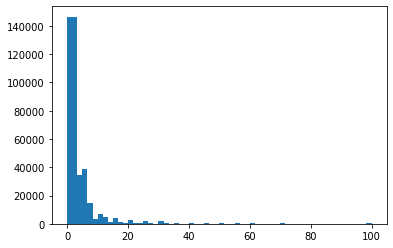

In [90]:
# histogram of emp counts
import numpy as np
import matplotlib.pyplot as mplp

hist = np.histogram(df_raw['EmpCnt_LocID'])
mplp.hist(df_raw['EmpCnt_LocID'], bins=60, range=(0,100))

# df_raw.hist(column='EmpCnt_LocID', bins=10)


In [45]:
# Do any company names have multiple DISTINCT geo levels, even if they have the same address?

# need df with distinct co name, address, and geo-levels
df_d = df_raw[['CompName', 'Address', 'City', 'geo_level']].drop_duplicates()

df_d_g = df_d.groupby(['CompName', 'Address', 'City'], observed=True).count()

# result: max value = 1, so there are no company locations duplicated due to having separate points for the 
# parcel vs. entry point location
df_d_g.geo_level.max()

1

In [61]:
# get a sample of similar strings to test fuzzywuzzy module

df_k = df_raw.loc[df_raw['CompName'].str.contains('Kaiser', na=False)][['CompName', 'SITE', 'Address', 'City', 'ZIP',  'NAICS', 'NAICSD', 'EmpCnt_LocID',
       'YearEstd', 'DateModified', 'DateVerified','ADDDAT', 'DateChange', 'latitude', 'longitude'
      ,'geo_level']].drop_duplicates()

df_k = df_k.sort_values(by=['CompName', 'Address'])
df_k.shape

df_k.to_csv(r'I:\Projects\Darren\EmpInventory\CSV\kaiser.csv')

# df_k[['CompName', 'SITE', 'Address', 'City', 'ZIP',  'NAICS', 'NAICSD', 'EmpCnt_LocID',
#        'YearEstd', 'DateModified', 'DateVerified','ADDDAT', 'DateChange', 'latitude', 'longitude'
#       ,'geo_level']].head(20)

In [105]:
# distinct lat-longs
# if you added an integer col to master table with "lat long ID" for each row, what would that accomplish?
# 
df_raw[['latitude', 'longitude']].drop_duplicates().shape

dful = df_raw[['latitude', 'longitude']].drop_duplicates()
dful.head()

df_recs = dful.to_records(index=False)
df_recs[4]

ll_id_dict = {}

for i, rec in enumerate(df_recs):
    k = rec[0] * rec[1] # get unique ID by multiplying lat * long? NO! does not create unique values
    if ll_id_dict.get(k):
        continue
    else:
        ll_id_dict[k] = i

    
# next thing to try (3/26/2021): get unique lats and give each their own UID, then do same for longs,
# which will give you new UIDs for each coord dimension, then can just concantenate ints instead of long floats?
# test will always be that number of UIDs must match number of unique lat-long pairs
    
print(len(ll_id_dict.keys()))
print(len(df_recs))

86416
146064
